Original dataset shape: (466285, 75)
Risk distribution (proportion):
Risk
0    0.786304
1    0.213696
Name: proportion, dtype: float64
After cleaning: (234946, 22)
Average values by Risk:


,loan_amnt,int_rate,annual_inc,dti,loan_to_income,installment_to_income
Risk,,,,,,
0,13214.394226,13.255943,73709.612302,15.937997,0.20059,0.006297
1,14673.695401,15.994094,65392.219799,18.356714,0.24487,0.007504


Credit grade default rate:


Risk,bad_rate
grade,
A,0.073429
B,0.149003
C,0.237053
D,0.308718
E,0.391712
F,0.441076
G,0.481084


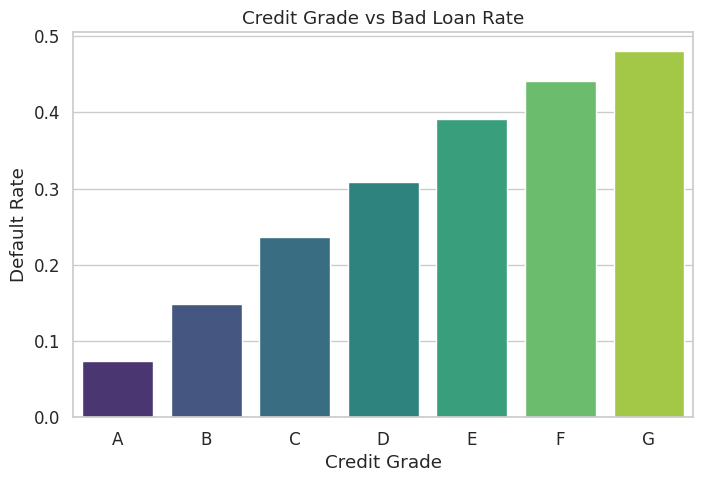

Top 10 risky loan purposes:


Risk,bad_rate
purpose,
small_business,0.312921
moving,0.239437
other,0.238286
medical,0.224320
debt_consolidation,0.224293
renewable_energy,0.209486
house,0.206179
vacation,0.199722
credit_card,0.189291


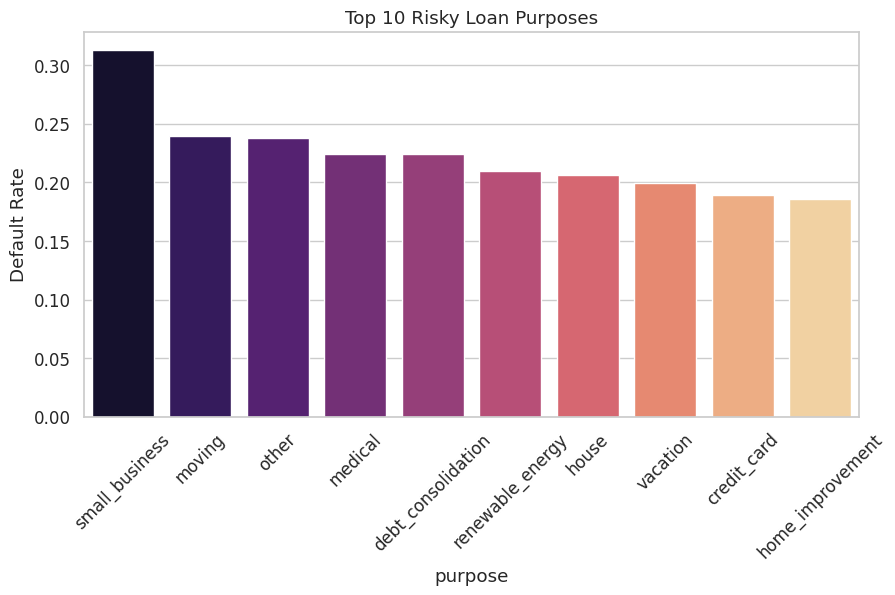

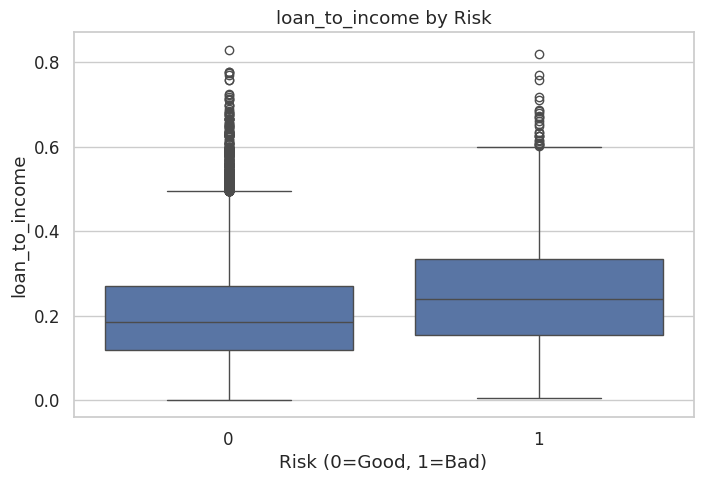

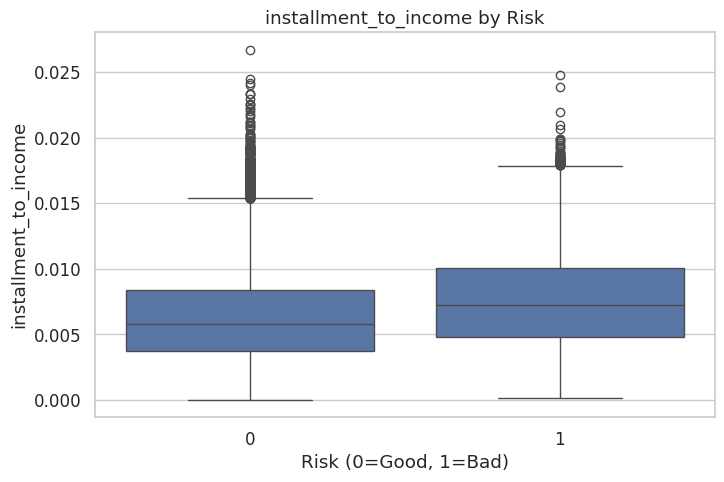

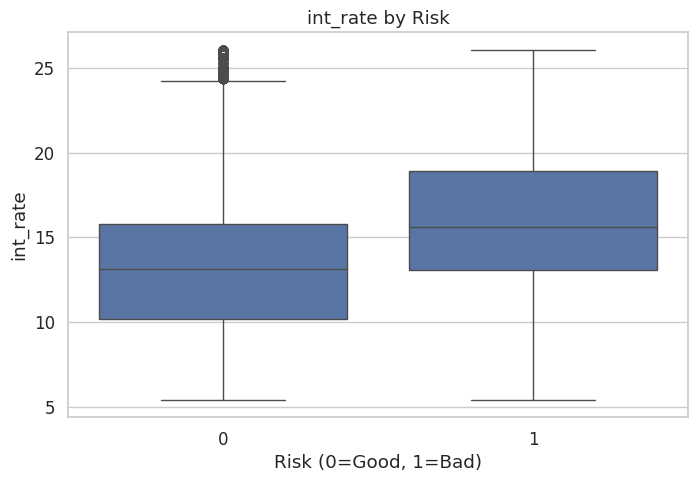

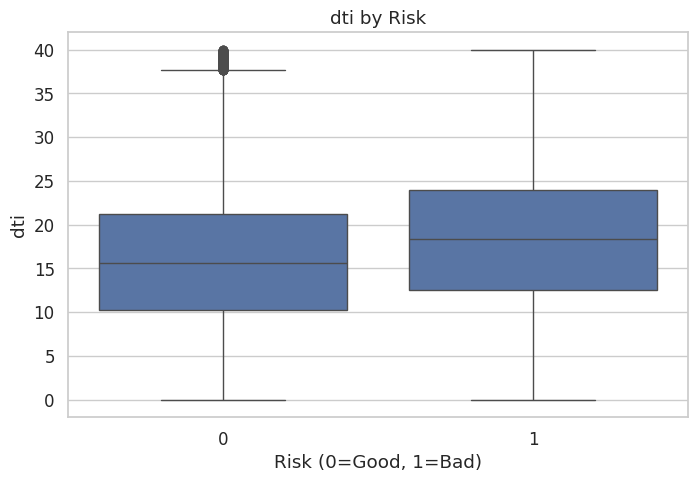

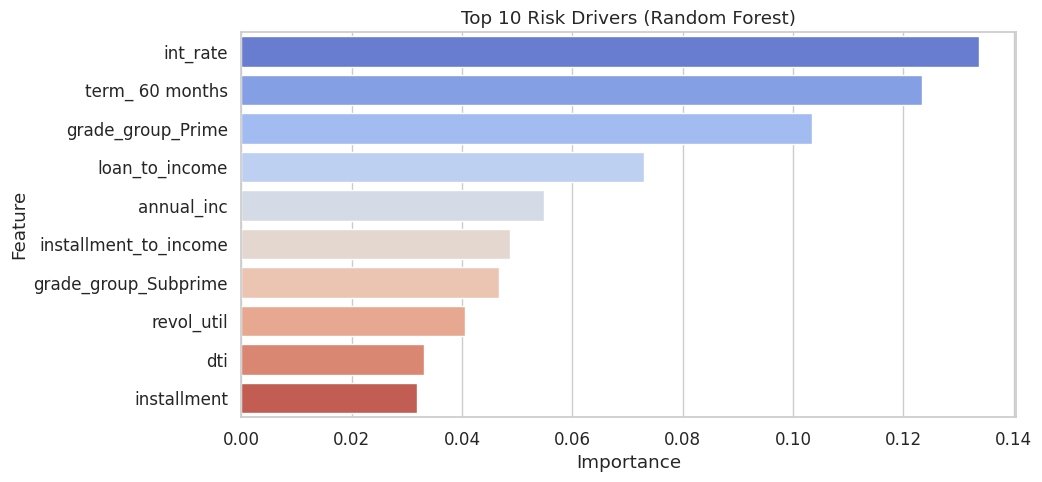

Top 5 Risk Drivers:


,Feature,Importance
1,int_rate,0.133753
14,term_ 60 months,0.123386
86,grade_group_Prime,0.103483
12,loan_to_income,0.072930
3,annual_inc,0.054920


Logistic Regression ROC-AUC: 0.6854
Random Forest ROC-AUC: 0.6870


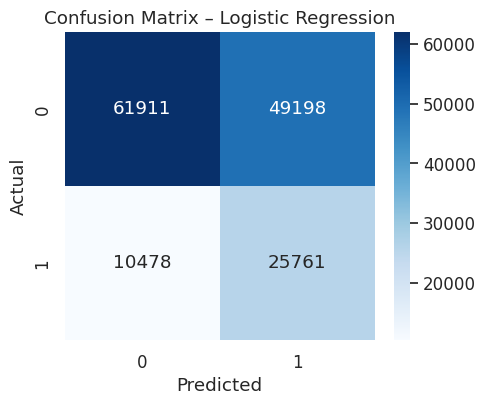

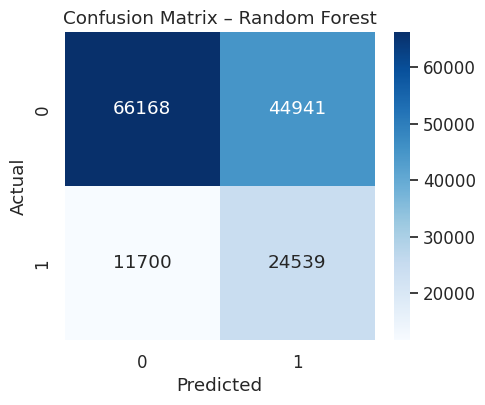

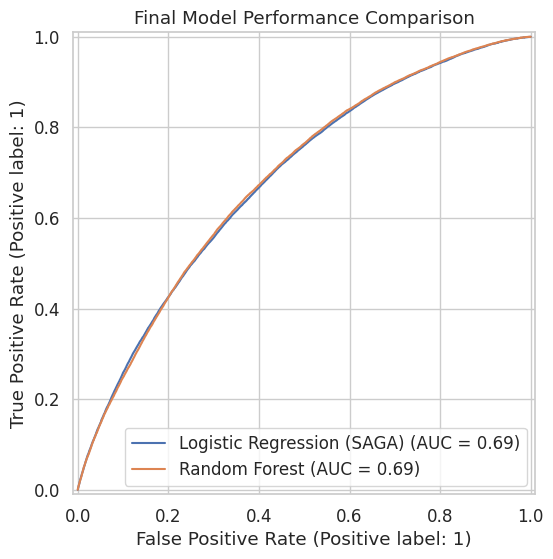

✅ FINAL ANALYST INSIGHTS

1️⃣ Bad loans exhibit significantly higher:
- Interest rates
- Debt-to-income ratios
- Loan-to-income burden

2️⃣ Credit grade default risk is monotonic:


Risk,bad_rate
grade,
A,0.073429
B,0.149003
C,0.237053
D,0.308718
E,0.391712
F,0.441076
G,0.481084



3️⃣ Random Forest outperforms Logistic Regression slightly:
- Higher ROC-AUC
- Better bad-loan recall

4️⃣ Strongest risk drivers:


,Feature,Importance
1,int_rate,0.133753
14,term_ 60 months,0.123386
86,grade_group_Prime,0.103483
12,loan_to_income,0.072930
3,annual_inc,0.054920


,Insight Source,Business Recommendation
0,Interest Rate Distribution,Avoid excessive interest rate increases that r...
1,Loan-to-Income Ratios,Introduce stricter affordability checks for hi...
2,High-Risk Loan Purposes,Apply enhanced underwriting for risky loan pur...
3,Credit Grade Risk Pattern,Continue using credit grades as a primary risk...


In [ ]:
# =========================================================
# CREDIT RISK ANALYSIS
# =========================================================

# -------------------------------
# 1️⃣ Import Libraries
# -------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

sns.set(style="whitegrid", font_scale=1.1)

# -------------------------------
# 2️⃣ Load Dataset
# -------------------------------
df = pd.read_csv('/content/drive/MyDrive/Dataset/3.1 loan_data_2007_2014.csv', low_memory=False)
print("Original dataset shape:", df.shape)
df.head()

# -------------------------------
# 3️⃣ Define Target Variable (Risk)
# -------------------------------
bad_status = ['Charged Off', 'Default', 'Late (31-120 days)']
df = df[df['loan_status'].isin(bad_status + ['Fully Paid'])]
df['Risk'] = df['loan_status'].apply(lambda x: 1 if x in bad_status else 0)

print("Risk distribution (proportion):")
print(df['Risk'].value_counts(normalize=True))

# -------------------------------
# 4️⃣ Feature Selection
# -------------------------------
features = [
    'loan_amnt','term','int_rate','installment',
    'grade','sub_grade','emp_length','home_ownership',
    'annual_inc','verification_status','purpose',
    'dti','delinq_2yrs','inq_last_6mths',
    'open_acc','pub_rec','revol_bal','revol_util',
    'total_acc','application_type','issue_d'
]

df = df[features + ['Risk']].copy()
df.head()

# -------------------------------
# 5️⃣ Data Cleaning
# -------------------------------
df['int_rate'] = df['int_rate'].astype(float)
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%y')

df['emp_length'] = df['emp_length'].fillna('Unknown')
df['revol_util'] = df['revol_util'].fillna(df['revol_util'].median())

df = df.dropna()
print("After cleaning:", df.shape)

# -------------------------------
# 6️⃣ Feature Engineering
# -------------------------------
df['loan_to_income'] = df['loan_amnt'] / df['annual_inc']
df['installment_to_income'] = df['installment'] / df['annual_inc']

df['grade_group'] = df['grade'].map({
    'A':'Prime','B':'Prime',
    'C':'Near-Prime','D':'Near-Prime',
    'E':'Subprime','F':'Subprime','G':'Subprime'
})

# -------------------------------
# 7️⃣ Exploratory Data Analysis (EDA)
# -------------------------------
numeric_cols = ['loan_amnt','int_rate','annual_inc','dti','loan_to_income','installment_to_income']

# 7a. Numeric summary by Risk
print("Average values by Risk:")
display(df.groupby('Risk')[numeric_cols].mean())

# 7b. Credit grade default rate
grade_risk = df.groupby(['grade','Risk']).size().unstack(fill_value=0)
grade_risk['bad_rate'] = grade_risk[1] / grade_risk.sum(axis=1)

print("Credit grade default rate:")
display(grade_risk[['bad_rate']])

# Barplot for grade risk
plt.figure(figsize=(8,5))
sns.barplot(x=grade_risk.index, y=grade_risk['bad_rate'], hue=grade_risk.index, palette='viridis', dodge=False)
plt.title('Credit Grade vs Bad Loan Rate')
plt.ylabel('Default Rate')
plt.xlabel('Credit Grade')
plt.show()

# 7c. Top 10 risky loan purposes
purpose_risk = df.groupby(['purpose','Risk']).size().unstack(fill_value=0)
purpose_risk['bad_rate'] = purpose_risk[1] / purpose_risk.sum(axis=1)

top_purposes = purpose_risk.sort_values('bad_rate', ascending=False).head(10)
print("Top 10 risky loan purposes:")
display(top_purposes[['bad_rate']])

plt.figure(figsize=(10,5))
sns.barplot(x=top_purposes.index, y=top_purposes['bad_rate'], hue=top_purposes.index, palette='magma', dodge=False)
plt.title('Top 10 Risky Loan Purposes')
plt.ylabel('Default Rate')
plt.xticks(rotation=45)
plt.show()

# 7d. Boxplots for numeric ratios by Risk
for col in ['loan_to_income','installment_to_income','int_rate','dti']:
    plt.figure(figsize=(8,5))
    sns.boxplot(x='Risk', y=col, data=df)
    plt.title(f'{col} by Risk')
    plt.xlabel('Risk (0=Good, 1=Bad)')
    plt.show()

# -------------------------------
# 8️⃣ Prepare Data for Modeling
# -------------------------------
# Drop high-cardinality time column before dummies
df_model = df.drop(columns=['issue_d']).copy()

# Convert categorical columns to dummies
df_model = pd.get_dummies(df_model, drop_first=True)

X = df_model.drop('Risk', axis=1)
y = df_model['Risk']

# Time-based train-test split
train_idx = df['issue_d'] < '2013-01-01'
X_train_raw, X_test_raw = X[train_idx], X[~train_idx]
y_train, y_test = y[train_idx], y[~train_idx]

# Scale all features after creating dummies
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

# -------------------------------
# 9️⃣ Predictive Modeling
# -------------------------------
# Logistic Regression with 'saga' solver
lr = LogisticRegression(
    solver='saga',
    max_iter=2000,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
lr.fit(X_train, y_train)

# Random Forest
rf = RandomForestClassifier(
    n_estimators=150,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# -------------------------------
# 🔟 Feature Importance (Random Forest)
# -------------------------------
feat_imp = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x='Importance', y='Feature', data=feat_imp.head(10), hue='Feature', palette='coolwarm', legend=False)
plt.title('Top 10 Risk Drivers (Random Forest)')
plt.show()

print("Top 5 Risk Drivers:")
display(feat_imp.head(5))

# -------------------------------
# 11️⃣ Model Evaluation
# -------------------------------
# ROC-AUC
roc_lr = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
roc_rf = roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])

print(f"Logistic Regression ROC-AUC: {roc_lr:.4f}")
print(f"Random Forest ROC-AUC: {roc_rf:.4f}")

# Confusion Matrices
for model_name, model_pred in [
    ('Logistic Regression', lr.predict(X_test)),
    ('Random Forest', rf.predict(X_test))
]:
    cm = confusion_matrix(y_test, model_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix – {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# ROC Curves
fig, ax = plt.subplots(figsize=(8,6))
RocCurveDisplay.from_estimator(lr, X_test, y_test, ax=ax, name='Logistic Regression (SAGA)')
RocCurveDisplay.from_estimator(rf, X_test, y_test, ax=ax, name='Random Forest')
plt.title('Final Model Performance Comparison')
plt.show()

# -------------------------------
# 12️⃣ Final Analyst Insights
# -------------------------------
print("✅ FINAL ANALYST INSIGHTS")
print("\n1️⃣ Bad loans exhibit significantly higher:")
print("- Interest rates")
print("- Debt-to-income ratios")
print("- Loan-to-income burden")

print("\n2️⃣ Credit grade default risk is monotonic:")
display(grade_risk[['bad_rate']])

print("\n3️⃣ Random Forest outperforms Logistic Regression slightly:")
print("- Higher ROC-AUC")
print("- Better bad-loan recall")

print("\n4️⃣ Strongest risk drivers:")
display(feat_imp.head(5))

# -------------------------------
# 13️⃣ Final Recommendations Table
# -------------------------------
recommendations = pd.DataFrame({
    'Insight Source': [
        'Interest Rate Distribution',
        'Loan-to-Income Ratios',
        'High-Risk Loan Purposes',
        'Credit Grade Risk Pattern'
    ],
    'Business Recommendation': [
        'Avoid excessive interest rate increases that raise default probability',
        'Introduce stricter affordability checks for high leverage borrowers',
        'Apply enhanced underwriting for risky loan purposes',
        'Continue using credit grades as a primary risk filter'
    ]
})

display(recommendations)
